In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.patches import Patch
import numpy as np
import importlib
import electricity_lib as ec_lib
import taipower_analyze_lib as analyze_lib

importlib.reload(ec_lib)
importlib.reload(analyze_lib)
pd.options.mode.chained_assignment = None  # default='warn'
# 設置微軟正黑體為全域字體
rcParams["font.family"] = "Microsoft JhengHei"

In [16]:
# 讀取充放電時間參數
meter_contract_volume_dict = analyze_lib.contract_df_to_dict(
    pd.read_excel(analyze_lib.METER_CONTRACT_FILE_PATH)
)
raw_data = pd.read_excel(analyze_lib.METER_DATA_FILE_PATH)
raw_data.drop(columns=analyze_lib.DEFAULT_DROP_COLS, inplace=True, errors="ignore")

METER_USAGE_COLS = analyze_lib.MeterUsageColumns()
ELEC_PRICE_COLS = analyze_lib.ElectricPriceColumns()
ELEC_PARAMS = analyze_lib.ElectricParameters(
    elec_type_dict=ec_lib.get_elec_type_dict(analyze_lib.CONTRACT_TYPE),
    release_hour_dict=ec_lib.get_release_hour_dict(
        analyze_lib.CONTRACT_TYPE, analyze_lib.RELEASE_TYPE
    ),
    charge_hour_dict=ec_lib.get_charege_hour_dict(
        analyze_lib.CONTRACT_TYPE, analyze_lib.CHARGE_TYPE
    ),
)
ELEC_PRICE_PARAMS = analyze_lib.ElecetricPriceParameters(
    charge_price_dict=ec_lib.get_charge_price_dict(analyze_lib.CONTRACT_TYPE),
    contract_price_dict=ec_lib.get_contract_price_dict(analyze_lib.CONTRACT_TYPE),
)
YEARLY_PROFIT_COLS = analyze_lib.YearlyProfitColumns()

# 將時間欄位轉換為日期時間格式
raw_data[METER_USAGE_COLS.time_col] = pd.to_datetime(
    raw_data[METER_USAGE_COLS.time_col]
)
raw_data[METER_USAGE_COLS.usage_col] = raw_data[analyze_lib.SUM_COLS].apply(
    lambda row: row.dropna().unique()[0] if row.nunique() == 1 else row.mode().iloc[0],
    axis=1,
)
raw_data[METER_USAGE_COLS.usage_col] = raw_data[METER_USAGE_COLS.usage_col] * 0.25
raw_data = raw_data.drop(columns=analyze_lib.SUM_COLS)

# 增加欄位，確定充放電狀態 & 充放電量
remain_battery_kw_list = []
battery_kwh_list = []
raw_data[
    [
        METER_USAGE_COLS.battery_kw_col,
        METER_USAGE_COLS.battery_kwh_col,
        METER_USAGE_COLS.usage_with_battery_col,
        METER_USAGE_COLS.charge_kwh_col,
        METER_USAGE_COLS.release_kwh_col,
    ]
] = pd.DataFrame(
    raw_data.apply(
        lambda row: analyze_lib.process_battery_usage(
            row,
            METER_USAGE_COLS,
            ELEC_PARAMS,
            remain_battery_kw_list,
            battery_kwh_list,
        ),
        axis=1,
    ).tolist(),
    index=raw_data.index,
)

# 計算電價、調整後電價、需量價金
raw_data[
    [
        ELEC_PRICE_COLS.elec_charge_price_col,
        ELEC_PRICE_COLS.elec_charge_price_with_battery_col,
        ELEC_PRICE_COLS.demand_price_col,
    ]
] = pd.DataFrame(
    raw_data.apply(
        lambda row: analyze_lib.cal_elec_price(
            row,
            METER_USAGE_COLS,
            ELEC_PARAMS.elec_type_dict,
            ELEC_PRICE_PARAMS.charge_price_dict,
        ),
        axis=1,
    ).tolist(),
)

# calculate new contract volume
# calculate new basic contract price
contract_monthly_basic_price = analyze_lib.cal_monthly_basic_price(
    meter_contract_volume_dict, ELEC_PRICE_PARAMS.contract_price_dict, ec_lib.UsageType
)
new_contract_volume_dict = analyze_lib.cal_new_contract_volume(
    raw_data, METER_USAGE_COLS, ELEC_PARAMS.elec_type_dict
)
new_monthly_basic_price = analyze_lib.cal_monthly_basic_price(
    new_contract_volume_dict, ELEC_PRICE_PARAMS.contract_price_dict, ec_lib.UsageType
)

monthly_data = analyze_lib.group_data_in_freq(
    raw_data,
    "ME",
    METER_USAGE_COLS,
    ELEC_PRICE_COLS,
)

yearly_data = analyze_lib.cal_year_profit(
    monthly_data,
    contract_monthly_basic_price,
    new_monthly_basic_price,
    ELEC_PRICE_COLS,
    YEARLY_PROFIT_COLS,
)

In [ ]:
expensive_daily_summary = analyze_lib.filter_expensive_usage_in_freq(
    raw_data, "D", METER_USAGE_COLS, ELEC_PRICE_COLS, ELEC_PARAMS
)
usage_data = expensive_daily_summary[METER_USAGE_COLS.usage_col]
average_power = usage_data.mean()
# 設置顏色：夏季（6月16日到10月15日）為橘色，其他為天藍色
colors = [
    (
        "orange"
        if (date.month > 5 or (date.month == 5 and date.day >= 16))
        and (date.month < 10 or (date.month == 10 and date.day <= 15))
        else "skyblue"
    )
    for date in expensive_daily_summary[METER_USAGE_COLS.time_col]
]

# 繪製柱狀圖
usage_data.plot(
    kind="bar",
    figsize=(16, 7),
    color=colors,
    edgecolor=colors,
    linewidth=1.2,
    alpha=0.8,
)

# 設置平均線
plt.axhline(y=average_power, color="red", linestyle="--")

# 設置 X 軸的顯示間隔
x_labels = (
    expensive_daily_summary[METER_USAGE_COLS.time_col].dt.strftime("%Y-%m-%d").tolist()
)
plt.xticks(range(0, len(x_labels), 15), x_labels[::15], fontsize=12)

# 圖表設置
plt.title("尖峰時段 用電總量", fontsize=16)
plt.xlabel("日期", fontsize=14)
plt.ylabel("電量 (kW)", fontsize=14)

legend_elements = [
    Patch(facecolor="orange", label="夏月尖峰需量"),
    Patch(
        facecolor="skyblue",
        label=(
            "非夏月半尖峰需量"
            if analyze_lib.CONTRACT_TYPE
            == ec_lib.ContractType.HIGH_PRESSURE_THREE_PHASE
            else "非夏月尖峰需量"
        ),
    ),
    Patch(color="red", label=f"平均值: {average_power:.2f}"),
]
plt.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
plt.close("all")

In [ ]:
# 按日期統計用電總量


expensive_15_usage = analyze_lib.filter_expensive_usage(
    raw_data, METER_USAGE_COLS, ELEC_PARAMS
)


max_demand_expensive_summary = analyze_lib.group_max_data_in_freq(
    expensive_15_usage,
    "D",
    METER_USAGE_COLS,
    ELEC_PRICE_COLS,
)



max_demand_expensive_summary[METER_USAGE_COLS.usage_col] = (
    max_demand_expensive_summary[METER_USAGE_COLS.usage_col] * 4
)


max_demand_expensive_summary[METER_USAGE_COLS.usage_with_battery_col] = (
    max_demand_expensive_summary[METER_USAGE_COLS.usage_with_battery_col] * 4
)


original_max_demand_power = max_demand_expensive_summary[
    METER_USAGE_COLS.usage_col
].max()


new_max_demand_power = max_demand_expensive_summary[
    METER_USAGE_COLS.usage_with_battery_col
].max()



# 設置顏色：夏季（6月16日到10月15日）為橘色，其他為天藍色


date_list = max_demand_expensive_summary[METER_USAGE_COLS.time_col]


fig, ax = plt.subplots(figsize=(16, 7))



summer_start_index, summer_end_index = 0, 0


for i in range(len(date_list)):


    date = date_list[i]


    if date.month == 5 and date.day == 16:
        summer_start_index = i


    elif date.month == 10 and date.day == 15:
        summer_end_index = i



ax.fill_between(
    range(len(date_list)),

    max_demand_expensive_summary[METER_USAGE_COLS.usage_col].values,
    label="Daily Summary",
    color="royalblue",
    linewidth=1.2,
    alpha=0.8,
)


ax.fill_between(
    range(summer_start_index, summer_end_index),

    max_demand_expensive_summary[METER_USAGE_COLS.usage_col].values[
        summer_start_index:summer_end_index
    ],
    label="Daily Summary",
    color="orange",

    linewidth=1.2,
    alpha=0.8,
)



# 繪製第二個 DataFrame 的折線圖


ax.fill_between(
    range(len(date_list)),

    max_demand_expensive_summary[METER_USAGE_COLS.usage_with_battery_col].values,
    label="Lower Daily Summary",
    color="lightblue",
    linewidth=1.2,
    alpha=0.8,
)


# 設置契約容量線


if ELEC_PARAMS.contract_type == ec_lib.ContractType.HIGH_PRESSURE_THREE_PHASE:


    contract_value = meter_contract_volume_dict.get(ec_lib.UsageType.PEAK)


    ax.hlines(
        y=contract_value,
        xmin=summer_start_index,
        xmax=summer_end_index,
        color="green",

        linestyle="-",
    )


    contract_value += meter_contract_volume_dict.get(ec_lib.UsageType.SEMI_PEAK)


    ax.hlines(
        y=[contract_value, contract_value],
        color="green",

        linestyle="-",
        xmin=[0, summer_end_index],
        xmax=[summer_start_index, len(date_list)],
    )


elif ELEC_PARAMS.contract_type == ec_lib.ContractType.HIGH_PRESSURE_BATCH:


    ax.axhline(
        y=meter_contract_volume_dict.get(ec_lib.UsageType.PEAK),
        color="green",

        linestyle="--",
    )


# 設置平均線


ax.axhline(y=original_max_demand_power, color="red", linestyle="--")


ax.axhline(y=new_max_demand_power, color="brown", linestyle="--")



# 設置 X 軸的顯示間隔


x_labels = date_list.dt.strftime("%Y-%m-%d")



tick_positions = range(0, len(x_labels), max(1, len(x_labels) // 15))  # 設置動態間隔


ax.set_xticks(tick_positions)


ax.set_xticklabels([x_labels[i] for i in tick_positions], rotation=90, fontsize=12)


ax.set_xlim(left=0, right=len(x_labels))  # X 軸從 0 開始


ax.set_ylim(bottom=0)



# 圖表設置


plt.title("尖峰時段 15分鐘最高需量", fontsize=16)


plt.xlabel("日期", fontsize=14)


plt.ylabel("最高需量 (kW)", fontsize=14)



legend_elements = [
    Patch(facecolor="orange", label="(原)夏月尖峰需量"),
    Patch(facecolor="royalblue", label="(原)非夏月尖峰需量"),
    Patch(facecolor="lightblue", label="新尖峰需量"),
    Patch(
        color="green",

        label="(原)合約需量",
    ),

    Patch(color="red", label=f"(原)尖峰最高需量: {original_max_demand_power:.2f}"),
    Patch(color="brown", label=f"新尖峰最高需量: {new_max_demand_power:.2f}"),
]


plt.legend(handles=legend_elements, fontsize=12, loc="upper right")


plt.show()

In [ ]:
plt.figure(figsize=(16, 7))

# 設定 X 軸位置
x = np.arange(len(contract_monthly_basic_price))

# 設定柱狀圖的寬度
width = 0.5
bar_width = width / 2

contract_bar = plt.bar(
    x - width / 2,
    contract_monthly_basic_price.values(),
    color="skyblue",
    width=bar_width,
    label="原契約月基本費",
)
plt.bar_label(
    contract_bar,
    labels=[f"{round(v):,}" for v in contract_monthly_basic_price.values()],
    fontsize=10,
)
new_contract_bar = plt.bar(
    x + width / 2,
    new_monthly_basic_price.values(),
    color="orange",
    width=bar_width,
    label="新契約月基本費",
)
plt.bar_label(
    new_contract_bar,
    labels=[f"{round(v):,}" for v in new_monthly_basic_price.values()],
    fontsize=10,
)

plt.xticks(x, contract_monthly_basic_price.keys(), fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))


plt.title("基本費用比較表", fontsize=14)
plt.xlabel("月份", fontsize=12)
plt.ylabel("基本費用", fontsize=12)

legend_elements = [
    Patch(facecolor="skyblue", label="原契約月基本費"),
    Patch(facecolor="orange", label="新契約月基本費"),
]
plt.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.show()

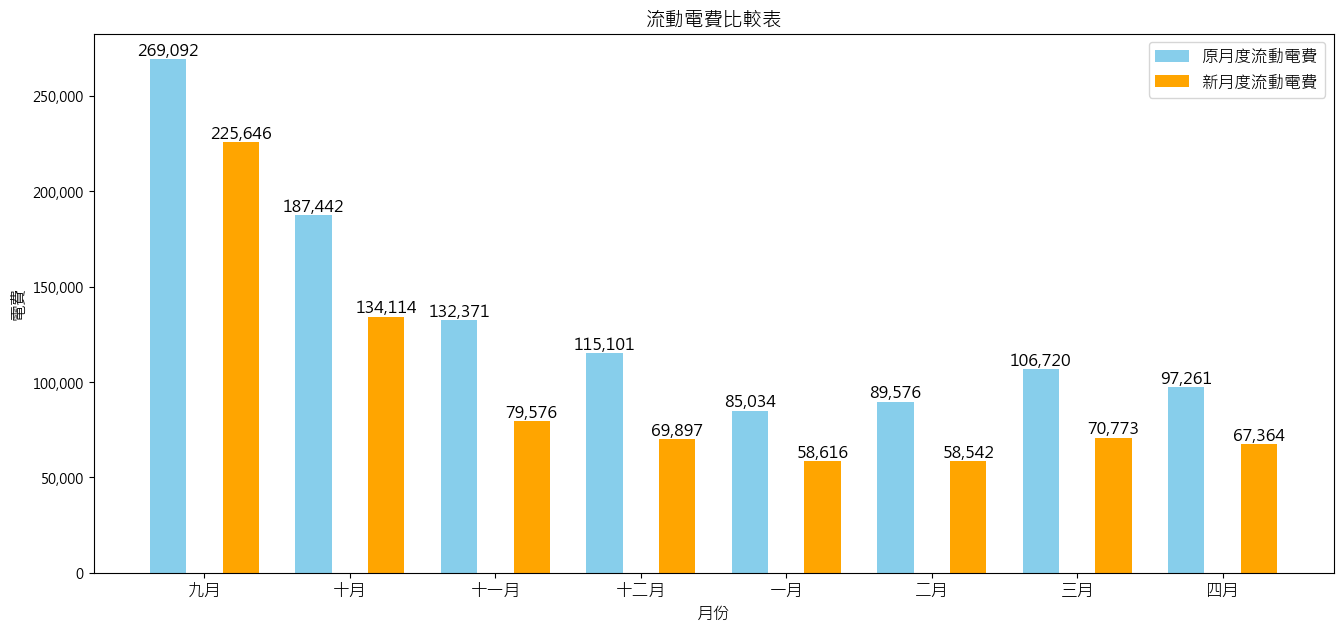

In [6]:
plt.figure(figsize=(16, 7))

# 設定 X 軸位置
x = np.arange(len(monthly_data[METER_USAGE_COLS.time_col]))

# 設定柱狀圖的寬度
width = 0.5
bar_width = width / 2

elec_charge_bar = plt.bar(
    x - width / 2,
    monthly_data[ELEC_PRICE_COLS.elec_charge_price_col],
    color="skyblue",
    width=bar_width,
    label="原月度流動電費",
)
plt.bar_label(
    elec_charge_bar,
    labels=[
        f"{round(v):,}" for v in monthly_data[ELEC_PRICE_COLS.elec_charge_price_col]
    ],
    fontsize=12,
)
elec_charge_with_battery_bar = plt.bar(
    x + width / 2,
    monthly_data[ELEC_PRICE_COLS.elec_charge_price_with_battery_col],
    color="orange",
    width=bar_width,
    label="新月度流動電費",
)
plt.bar_label(
    elec_charge_with_battery_bar,
    labels=[
        f"{round(v):,}"
        for v in monthly_data[ELEC_PRICE_COLS.elec_charge_price_with_battery_col]
    ],
    fontsize=12,
)
display_month_list = monthly_data[METER_USAGE_COLS.time_col].map(
    lambda x: analyze_lib.MONTH_LIST[x.month - 1]
)
plt.xticks(x, display_month_list, fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))


plt.title("流動電費比較表", fontsize=14)
plt.xlabel("月份", fontsize=12)
plt.ylabel("電費", fontsize=12)

legend_elements = [
    Patch(facecolor="skyblue", label="原月度流動電費"),
    Patch(facecolor="orange", label="新月度流動電費"),
]
plt.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.show()

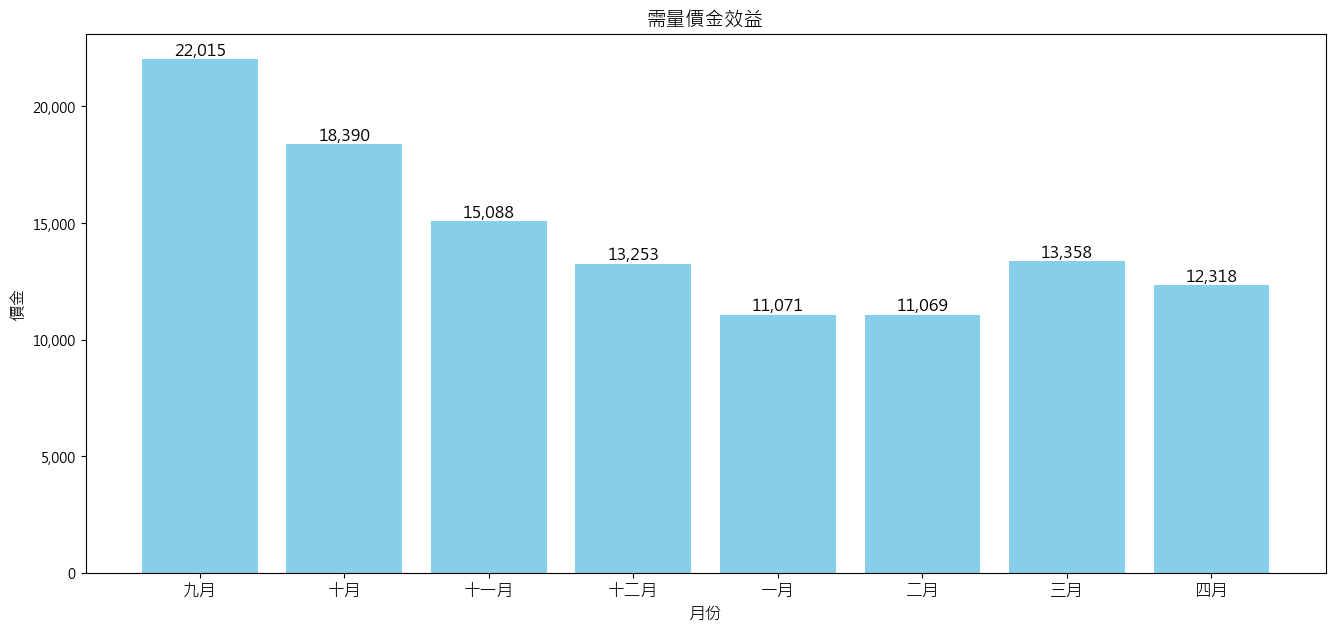

In [11]:
plt.figure(figsize=(16, 7))

# 設定 X 軸位置
x = np.arange(len(monthly_data[METER_USAGE_COLS.time_col]))

# 設定柱狀圖的寬度
width = 0.5

dr_price_bar = plt.bar(
    x,
    monthly_data[ELEC_PRICE_COLS.demand_price_col],
    color="skyblue",
    label="需量價金",
)
plt.bar_label(
    dr_price_bar,
    labels=[f"{round(v):,}" for v in monthly_data[ELEC_PRICE_COLS.demand_price_col]],
    fontsize=12,
)
display_month_list = monthly_data[METER_USAGE_COLS.time_col].map(
    lambda x: analyze_lib.MONTH_LIST[x.month - 1]
)
plt.xticks(x, display_month_list, fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))


plt.title("需量價金效益", fontsize=14)
plt.xlabel("月份", fontsize=12)
plt.ylabel("價金", fontsize=12)
plt.show()

In [ ]:
plt.figure(figsize=(16, 7))

# 設定 X 軸位置
x = np.arange(len(monthly_data[METER_USAGE_COLS.time_col]))

# 設定柱狀圖的寬度
width = 0.5
bar_width = width / 2

charge_price_bars = plt.bar(
    x - width / 2,
    -(monthly_data[METER_USAGE_COLS.charge_kwh_col]),
    color="skyblue",
    width=bar_width,
    label="充電電費",
)
plt.bar_label(
    charge_price_bars,
    labels=[f"{round(v):,}" for v in -(monthly_data[METER_USAGE_COLS.charge_kwh_col])],
    fontsize=12,
)
release_price_bars = plt.bar(
    x + width / 2,
    monthly_data[METER_USAGE_COLS.release_kwh_col],
    color="orange",
    width=bar_width,
    label="放電電費",
)
plt.bar_label(
    release_price_bars,
    labels=[f"{round(v):,}" for v in monthly_data[METER_USAGE_COLS.release_kwh_col]],
    fontsize=12,
)
display_month_list = monthly_data[METER_USAGE_COLS.time_col].map(
    lambda x: analyze_lib.MONTH_LIST[x.month - 1]
)
plt.xticks(x, display_month_list, fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))


plt.title("每月電池充放電量表", fontsize=14)
plt.xlabel("月份", fontsize=12)
plt.ylabel("充放電量", fontsize=12)

legend_elements = [
    Patch(facecolor="skyblue", label="充電量"),
    Patch(facecolor="orange", label="放電量"),
]
plt.legend(handles=legend_elements, fontsize=12, loc="upper right")
plt.show()